In [1]:
!pip install deap
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.3 MB/s eta 0:00:00


**Dataset:** https://archive.ics.uci.edu/ml/datasets/Car+Evaluation

**Algorithm:** SVM 

In [2]:
import numpy as np
from pandas import read_csv

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'

data = read_csv(url, header=None, usecols=range(0, 7))
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety','class']
data.columns = col_names
X = data.iloc[:, 0:6]
y = data.iloc[:, 6:7]

X

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med
...,...,...,...,...,...,...
1723,low,low,5more,more,med,med
1724,low,low,5more,more,med,high
1725,low,low,5more,more,big,low
1726,low,low,5more,more,big,med


In [3]:
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])
X = encoder.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
X

,buying,maint,doors,persons,lug_boot,safety
0,1,1,1,1,1,1
1,1,1,1,1,1,2
2,1,1,1,1,1,3
3,1,1,1,1,2,1
4,1,1,1,1,2,2
...,...,...,...,...,...,...
1723,4,4,4,3,2,2
1724,4,4,4,3,2,3
1725,4,4,4,3,3,1
1726,4,4,4,3,3,2


In [5]:
y

array([2, 2, 2, ..., 2, 1, 3])

In [6]:
from sklearn import model_selection
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)

In [37]:
svm_classifier = svm.SVC()
cv_results = model_selection.cross_val_score(svm_classifier,
                                                 X_train,
                                                 y_train,
                                                 cv=kfold,
                                                 scoring='accuracy')

print('[SVM] mean: ',cv_results.mean())

[SVM] mean:  0.9623605463455324


In [8]:
dt_classifier = DecisionTreeClassifier()
cv_results = model_selection.cross_val_score(dt_classifier,
                                                 X_train,
                                                 y_train,
                                                 cv=kfold,
                                                 scoring='accuracy')

print('[DT] mean: ',cv_results.mean())

[DT] mean:  0.9783234282139505


In [9]:
knn_classifier = KNeighborsClassifier()
cv_results = model_selection.cross_val_score(knn_classifier,
                                                 X_train,
                                                 y_train,
                                                 cv=kfold,
                                                 scoring='accuracy')

print('[KNN] mean: ',cv_results.mean())

[KNN] mean:  0.9370451464915025


In [10]:
gb_classifier = GradientBoostingClassifier()
cv_results = model_selection.cross_val_score(gb_classifier,
                                                 X_train,
                                                 y_train,
                                                 cv=kfold,
                                                 scoring='accuracy')

print('[GB] mean: ',cv_results.mean())

[GB] mean:  0.9891565008862475


In [100]:
from sklearn.metrics import roc_curve, auc

def get_mean_AUC(y_test, y_scores):
  # Compute ROC curve and AUC for each class
  n_classes = y_scores.shape[1]
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Aggregate the results
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  mean_tpr /= n_classes
  roc_auc_macro = auc(all_fpr, mean_tpr)

  return all_fpr, mean_tpr, roc_auc_macro

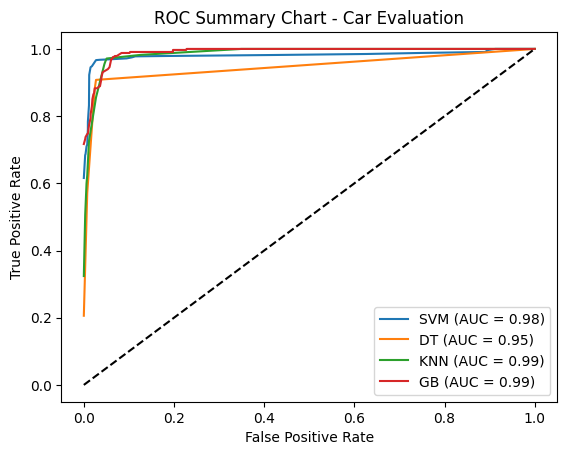

In [106]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train, y_train are the training data
# Assuming X_test, y_test are the test data

# Convert y_test to one-hot encoded matrix
n_classes = len(np.unique(y_train))
y_test = label_binarize(y_test, classes=np.arange(n_classes))

# Fit the model to the training data
svm_classifier.fit(X_train,y_train)
dt_classifier.fit(X_train,y_train)
knn_classifier.fit(X_train,y_train)
gb_classifier.fit(X_train,y_train)

# Predict probabilities for each class
y_scores1 = svm_classifier.decision_function(X_test)
y_scores2 = dt_classifier.predict_proba(X_test)
y_scores3 = knn_classifier.predict_proba(X_test)
y_scores4 = gb_classifier.decision_function(X_test)

all_fpr1, mean_tpr1, roc_auc_macro1 = get_mean_AUC(y_test, y_scores1)
all_fpr2, mean_tpr2, roc_auc_macro2 = get_mean_AUC(y_test, y_scores2)
all_fpr3, mean_tpr3, roc_auc_macro3 = get_mean_AUC(y_test, y_scores3)
all_fpr4, mean_tpr4, roc_auc_macro4 = get_mean_AUC(y_test, y_scores4)

# Plot the ROC curve for each class
plt.figure()
plt.plot(all_fpr1, mean_tpr1, label='SVM (AUC = %0.2f)' % roc_auc_macro1)
plt.plot(all_fpr2, mean_tpr2, label='DT (AUC = %0.2f)' % roc_auc_macro2)
plt.plot(all_fpr3, mean_tpr3, label='KNN (AUC = %0.2f)' % roc_auc_macro3)
plt.plot(all_fpr4, mean_tpr4, label='GB (AUC = %0.2f)' % roc_auc_macro4)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Summary Chart - Car Evaluation')
plt.legend(loc='lower right')
plt.show()
